# Clustering Methods
During this experiment, we will implement clustering methods from scratch using Pytorch.<br>
The [Mall Customer Segmentation Data](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python/discussion/82190) will be used the clustering.

In [39]:
import os
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

### Read csv using Pandas

In [40]:
customers = pd.read_csv(os.path.join('data', 'Mall_Customers.csv'))

In [41]:
customers.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Transform string to categorical

In [42]:
le = LabelEncoder()
customers['Gender'] = le.fit_transform(customers['Gender'])

In [43]:
for cl, lbl in zip(le.classes_, le.transform(le.classes_)):
    print(cl, ':', lbl)

Female : 0
Male : 1


In [44]:
# Convert to Pytorch tensor
X = torch.from_numpy(customers.values).float()

### Implementation of Principal Component Analysis
In this section, we will use PCA to reduce the number of feature to two, in order to visualize the data in 2D.

In [45]:
# Covariance function
# cov(X) = (X - E[X])T (X - E[X])
def cov(A):
    A -= A.mean(dim=0, keepdim=True)
    fact = 1.0 / (A.shape[0] - 1)
    cov = fact * A.T.mm(A)
    return cov

# PCA function
def pca(A, target_dim=2):
    cov_a = cov(A)
    
    # Get the right singular vector of the covariance
    _, _, V = torch.svd(cov_a)

    # Get the first kth singular vector of the covariance
    transform_mat = V[:, :target_dim]

    # Multiply the data by the transform matrix to get the reduced data
    A_reduce = A.mm(transform_mat)
    return A_reduce, transform_mat

In [46]:
X_pca = pca(X)[0]

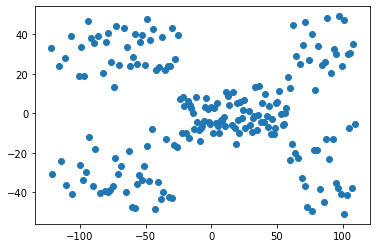

In [47]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])

Our goal is to separate the data into groups where the samples in each group are similar.

### Standardize the data
The K-means method is a distance based approach for clustering.<br>
It is mandatory to standardize the data to prevent the features with higher values to contribute more than the others.

In [48]:
X_s = StandardScaler().fit_transform(X_pca)
X_s = torch.from_numpy(X_s).float()

### K-Means Clustering
K-means algorithm is an iterative approach that tries to partition a dataset into $K$ predefined clusters where each data point belongs to only one cluster.
            
This algorithm works that way:
- specify number of clusters $K$
- randomly initialize one centroid in space for each cluster
- for each point, compute the euclidean distance between the point and each centroid and assign the point to the closest centroid
- change the centroid value based on the points present in each cluster and repeat the previous step until the centroid does not change anymore

The approach, K-means follows to solve this problem is called Expectation-Maximization. The E-step assign each point to a cluster, and the M-step refines the value of centroid based on the points inside each cluster.

More formally, the objective function to minimize is as follows:<br>
$$
    J = \sum_{i=1}^{m} \sum_{k=1}^{K} \mathbb{I}(z_i = k)||x_i - \mu_k||_2^2
$$<br>
where $z_i$ is the cluster assigned to $x_i$ and $\mu_k$ is the mean of the cluster $k$.

The E-step is defined as:<br>
$$
    z_i^{*} = \text{argmin}_{k} ||x_i - \mu_k||_2^2
$$<br>

And the M-step is defined as:<br>
$$
    \mu_k = \frac{1}{\sum_{i=1}^m \mathbb{I}(z_i = k)} \sum_{i=1}^m  x_i\mathbb{I}(z_i = k)
$$<br>

In practice, we should run multiple K-means with different initialization of the centroids and keep the parameters that min
Since K-means is a distance based algorithm, is it mandatory to standardize the data. 

In [49]:
class KMeansClustering():
    def __init__(self, n_clusters=5):
        # Number of clusters
        self.n_clusters = n_clusters
        self.centroids = None
        
    
    def fit_transform(self, X, n_iter=20):
        size = X.shape[0]
        # Find min and max values to generate a random centroid in this range
        xmax = X.max(dim=0)[0].unsqueeze(1)
        xmin = X.min(dim=0)[0].unsqueeze(1)
        
        dists = torch.zeros((size, self.n_clusters))
        best_loss = 1e10
        pred = None
        # Repeat n number of time`
        for _ in range(n_iter):
            # Initialize n centroids
            centroids = (xmin - xmax) * torch.rand((X.shape[1], self.n_clusters)) + xmax
            old_loss = -1
            while 1:
                # E-step: assign each point to a cluster
                for i in range(self.n_clusters):
                    ctr = centroids[:, i].unsqueeze(1)
                    dists[:, i] = (X - ctr.T).pow(2).sum(dim=1).sqrt()
                dists_min, labels = dists.min(dim=1)
                
                # M-step: re-compute the centroids based on the new labeled data
                for i in range(self.n_clusters):
                    idx = torch.where(labels == i)[0]
                    if len(idx) == 0:
                        continue
                    centroids[:, i] = X[idx].mean(dim=0)
                    
                # Loss is the sum of the distance of the points respectively to their centroid
                new_loss = dists_min.sum()
                if old_loss == new_loss:
                    break
                old_loss = new_loss
            if new_loss < best_loss:
                best_loss = new_loss
                pred = labels
        # Return the best prediction based on the objective function
        return pred

In [50]:
kms = KMeansClustering(n_clusters=5)
pred = kms.fit_transform(X_s)

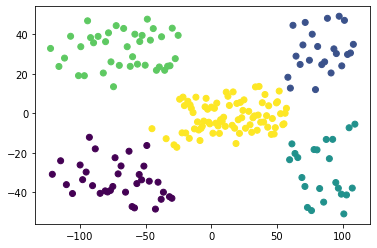

In [51]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred)

The result is pretty satisfying. Each cluster is well separated from each other.<br>
Let's see if we can get the same result using a Gaussian Mixture model.

### Gaussian Mixture Model
In order to understand how we train a Gaussian Mixture model, we must explain the expectation-maximization algorithm (EM) first.<br>
The EM algorithm is a general technique for finding maximum likelihood solutions for probabilistic models having latent variables. EM is an iterative algorithm that starts from an initial estimate of the parameters of a probabilistic model $\boldsymbol{\theta}$ and then proceeds to iteratively update $\boldsymbol{\theta}$ until convergence. This algorithm consists to iteratively apply an expectation step and a maximization step.
            
Let's consider the EM algorithm for a multivariate Gaussian Mixture model with $K$ mixture components, observed variables $\boldsymbol{X}$ and latent variables $\boldsymbol{Z}$ such as:<br>

$$
\large
\begin{aligned}
    P(\boldsymbol{x}_i | \boldsymbol{\theta}) &= \sum_{k=1}^{K} \pi_k P(\boldsymbol{x}_i | \boldsymbol{z}_i, \boldsymbol{\theta}_k)\\
    &= \sum_{k=1}^{K} P(\boldsymbol{z}_i = k) \mathcal{N}(\boldsymbol{x}_i; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
\end{aligned}
$$<br>
where each component of the mixture model is the normal distribution.
Let's see why the MLE of a gaussian mixture model is hard to compute. The likelihood of a gaussian mixture distribution is:<br>
$$
\large
    L(\boldsymbol{\theta} | \boldsymbol{X}) = \prod_{i=1}^N\sum_{k=1}^{K} \pi_k \mathcal{N}(\boldsymbol{x}_i; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
$$<br>

This the log-likelihood is as follows:<br>
$$
\large
    \mathcal{L}(\boldsymbol{\theta} | \boldsymbol{X}) = \sum_{i=1}^N \log\left(\sum_{k=1}^{K} \pi_k \mathcal{N}(\boldsymbol{x}_i; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)\right)
$$<br>

Because of the sum inside the $\log$, we cannot estimate $\boldsymbol{\mu}_k$ and $\boldsymbol{\sigma^2}$ without knowing $\boldsymbol{Z}$. That is why we would use EM in this kind of situation.

The EM algorithm has two steps, the expectation step known as E-step, assigns to each data point the probability that they belong to each
components of the mixture model. Whereas the maximization step, known as M-step, re-evaluate the parameters of each mixture component based on the estimated values generated in the E-step.

More formally, during the E-step, we calculate the likelihood of each data point using the estimated parameters:<br>
$$
\large
    f(\boldsymbol{x_i}|\mu_k, \boldsymbol{\Sigma}_k) = \frac{1}{\sqrt{(2\pi)^m|\boldsymbol{\Sigma}_k|}} \exp\left(-\frac{(\boldsymbol{x}_i - \boldsymbol{\mu}_k)^\top \boldsymbol{\Sigma}_k^{-1}(\boldsymbol{x}_i - \boldsymbol{\mu}_k)}{2}\right)
$$<br>
where $m$ is the number of features in the input data.

Then we compute the probability that $\boldsymbol{x}_i$ came from the $k^{th}$ gaussian distribution:<br>
$$
\large
    p_{ik} = \frac{\pi_k f(\boldsymbol{x_i}|\mu_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^{K} \pi_j f(\boldsymbol{x_i}|\mu_j, \boldsymbol{\Sigma}_j)}
$$<br>

For the M-step, we update the parameters of the mixture as follows:<br>
$$
\large
\begin{aligned}
    \pi_k &= \frac{1}{N}\sum_{i=1}^{N} p_{ik}\\
    \boldsymbol{\mu}_k &= \frac{1}{N} \sum_{i=1}^{N} p_{ik} \boldsymbol{x_i}\\
    \boldsymbol{\Sigma}_k &= \frac{1}{\sum_{i=1}^{N} p_{ik}} \sum_{i=1}^{N} p_{ik} (\boldsymbol{x}_i - \boldsymbol{\mu}_k) (\boldsymbol{x}_i - \boldsymbol{\mu}_k)^\top
\end{aligned}
$$

In [132]:
class GaussianMixture():
    def __init__(self, n_components, n_iter):
        # Number of gaussian distribution in the mixture
        self.n_components = n_components
        # Number of E-step, M-step iterations
        self.n_iter = n_iter
        
    def gaussian_likelihood(self, X, idx):
        two_pi = torch.tensor(2 * math.pi, dtype=torch.float64)
        # Factor before the exp() expression
        fact = 1 / torch.sqrt(torch.pow(two_pi, X.shape[0]) * torch.det(self.sigma[idx]))
        X_minus_mu = X - self.mu[idx].T
        
        sigma_inv = torch.inverse(self.sigma[idx])
        
        ret = fact * torch.exp(-0.5 * X_minus_mu.mm(sigma_inv).mm(X_minus_mu.T))
        return ret
        
    def e_step(self, X):
        for j in range(self.n_components):
            for i in range(self.n_samples):
                # For each sample and each gaussian, compute the likelihood that
                # the sample comes from this gaussian
                self.likelihoods[i][j] = self.gaussian_likelihood(X[i], j)
                
        # Tensor to hold the probabilities that each data belongs to each gaussian
        prob_num = self.priors.T * self.likelihoods
        prob_den = prob_num.sum(dim=1).unsqueeze(1)
        self.probs = prob_num / prob_den
        
    def m_step(self, X):
        for j in range(self.n_components):
            probs_j = self.probs[:, j]
            self.priors[j] = probs_j.sum() / self.n_samples
            
            probs_j_uns = probs_j.unsqueeze(1)
            
            # CHECK HERE: / by n_samples ? not probs ?
            self.mu[j] = (probs_j_uns * X).sum(dim=0).unsqueeze(1)
            self.mu[j] /= self.n_samples
            
            X_minus_mu = X - self.mu[j].T
            self.sigma[j].fill_(0.)
            for i in range(self.n_samples):
                row = X_minus_mu[i, :].unsqueeze(1)
                self.sigma[j] += probs_j[i] * row.mm(row.T)
            self.sigma[j] /= probs_j.sum()  
            
    def fit_predict(self, X):
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        
        # Parameter initialization: mean & covariance and class priors
        self.sigma = torch.zeros((self.n_components, self.n_features, self.n_features), dtype=torch.float64)
        
        self.mu = torch.zeros((self.n_components, self.n_features, 1), dtype=torch.float64)
        # Initialize class prior uniformly
        self.priors = torch.zeros((self.n_components, 1), dtype=torch.float64).fill_(1 / self.n_components)
        self.probs = None
        
        # Set the covariance parameter of each components to the covariance of the data
        X_m = X - X.mean()
        X_cov = X_m.T.mm(X_m)
        for j in range(self.n_components):
            self.sigma[j] = X_cov.clone()
            # Select a random sample as the mean of each gaussian
            self.mu[j] = X[torch.randint(0, self.n_samples, (1,))].T
        
        # Tensor to hold the likelihoods for each data and each gaussian
        self.likelihoods = torch.zeros((self.n_samples, self.n_components), dtype=torch.float64)
        
        # Do n times the e-step and m-step
        for _ in range(self.n_iter):
            # E-step
            self.e_step(X)
            # M-step
            self.m_step(X)
            
        return self.probs.argmax(dim=1)

In [133]:
gmm = GaussianMixture(n_components=5, n_iter=10)
X_s = X_s.type(torch.DoubleTensor)
pred_gmm = gmm.fit_predict(X_s)

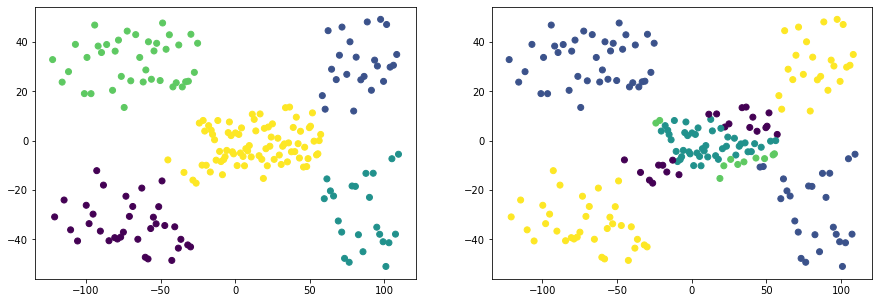

In [134]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=pred)
ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_gmm)

In [155]:
x_1 = np.linspace(-10, 10, 50)
x_2 = np.linspace(-10, 10, 50)

xx, yy = np.meshgrid(x_1, x_2)
xy = torch.from_numpy(np.column_stack([xx.flat, yy.flat]))

z = np.zeros(xy.shape[0],)
for i in range(z.shape[0]):
    z[i] = gmm.gaussian_likelihood(xy[i], 3)
z = z.reshape(xx.shape)

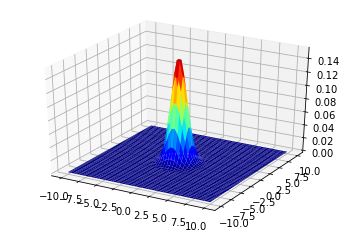

In [159]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, z, cmap='jet')